In [1]:
# Model design
import agentpy as ap
import networkx as nx
import numpy as np
import random 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

## Introduction 
This is a very simple world model to explore the tech adoption in a population. I plan to extend this to include additional resources in the future including resources, types of AI, and community resource pooling, however this is just a start.


A logical place to start when modeling technology adoption is Rogers' model of innovation diffusion:



**Diffusion of Innovations (5th Edition)** by Everett M. Rogers
- **Publisher**: Free Press  
- **Year**: 2003 (latest edition)  
- **ISBN**: 978-0743222099  

This book is the definitive work on the subject, presenting the theory and the five stages of the diffusion process:
1. Knowledge
2. Persuasion
3. Decision
4. Implementation
5. Confirmation

Key factors affecting the adoption of innovations include:
- **Innovation attributes**: Relative advantage, compatibility, complexity, trialability, and observability.  
- **Adopter categories**: Innovators, early adopters, early majority, late majority, and laggards.  

The book also includes case studies and practical applications across disciplines, making it a comprehensive resource for understanding how innovations spread in societies.

This model will begin with a simple exploration of the adopter categories and be expanded in future iterations.


## Simple Exploration

This expands on the previous one with the addition of funds (money) and AI units that people consume but can also contribute to. I also added a metric of the gini coeficient to measure economic disparity.

In [2]:
categories = ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard'] # tech adoption categories
probabilities = [0.05, 0.1, 0.35, 0.35, 0.15] # fraction of the population that falls into each category
thresholds = [0.0, 0.3, 0.7, 0.8, 0.9] # threshold above which fraction of adopted neighbors will cause agent to adopt

rng = np.random.default_rng()

samples = rng.choice(categories, p=probabilities)
samples

def tech_categorical(categories,probabilities,population_size=100, rng=np.random.default_rng()):
    rng = np.random.default_rng()

    samples = rng.choice(categories, size=population_size,p=probabilities)
    return samples

## Agentpy Agent definition

I will use [Agentpy](https://agentpy.readthedocs.io/en/latest/) as my python based agent modeling framework. 

We will start by defining the attributes and behaviour of the agent or in this case person adopting the tech.

In [33]:
class InnovationAgent(ap.Agent):
    def setup(self):
        """
        Initializes the agent's adoption state, assigns it to a category, and sets its budget.
        """
        self.adopted = False

        # Assign category and probabilities
        rng = np.random
        self.category_idx = rng.choice(len(self.p.categories), p=self.p.probabilities)
        self.category = self.p.categories[self.category_idx]

        # Assign random budget for the agent
        self.money = rng.uniform(0, 200)  # Example range

    def can_use_ai(self):
        """
        Checks if the agent can use AI resources based on their money and availability.
        Returns:
            bool: True if the agent can use AI, False otherwise.
        """
        return self.money >= self.p.ai_cost and self.model.ai_resources > 0

    def num_adopted_neighbors(self):
        """
        Counts the number of neighboring agents who have adopted the innovation.
        """
        neighbors = self.network.neighbors(self)
        return sum(n.adopted for n in neighbors)

    def neighbor_adopted_frac(self):
        """
        Calculates the fraction of neighboring agents who have adopted the innovation.
        Returns:
            float: Fraction of adopters or 0 if there are no neighbors.
        """

        # Get the neighbors of the current agent
        neighbors = self.network.neighbors(self)
        
        # Check adoption status for each neighbor
        adopted = [n.adopted for n in neighbors]
        len_neighbors = len(adopted)

        # Handle case where there are no neighbors
        if len_neighbors == 0:
            return 0

        # Calculate and return the fraction of adopters
        num_adopters = sum(adopted)
        return num_adopters / len_neighbors

    def adopt_use_contribute(self):
        """
        Handles the agent's behavior: adopting, using, or contributing to AI resources.
        """
        # Add money probabilistically every turn

        self.money *= np.random.uniform(1,1.1)
        self.money += np.random.uniform(self.p.standard_money_gain_min, self.p.standard_money_gain_max)
        
        # decide whether to use
        if self.adopted and self.can_use_ai():
            self.use_technology()
            
        # Decide whether to contribute
        if (np.random.uniform() < self.p.contributor_fraction) or (self.category == "innovator"):
            # print("contribute to ai")
            self.contribute_to_ai()

        elif not self.adopted:
            # Innovators adopt unconditionally if they can afford AI
            if self.category == 'innovator' and self.can_use_ai():
                self.adopted = True

            # Other categories adopt based on a threshold and affordability
            elif self.category in ['early_adopter', 'early_majority', 'late_majority', 'laggard']:
                adopted_frac = self.neighbor_adopted_frac()
                threshold = self.p.thresholds[self.category_idx]

                if adopted_frac >= threshold and self.can_use_ai():
                    self.adopted = True
                    self.use_technology()

    def use_technology(self):
        """
        Deducts the cost of using AI and reduces global AI resources.
        """
        # print("used ai resource")
        self.money -= self.p.ai_cost
        self.model.ai_resources -= 1

    def contribute_to_ai(self):
        """
        Generates and contributes additional money and AI resources to the system.
        """
        generated_money = np.random.uniform(self.p.ai_money_gain_min, self.p.ai_money_gain_max)
        generated_resources = np.random.randint(self.p.resource_gain_min, self.p.resource_gain_max + 1)
        # print("{} resources added".format(generated_resources))

        self.money += generated_money
        self.model.ai_resources += generated_resources


In [34]:
def gini(x):

    """ Calculate Gini Coefficient """
    # By Warren Weckesser https://stackoverflow.com/a/39513799
    
    x = np.array(x)
    mad = np.abs(np.subtract.outer(x, x)).mean()  # Mean absolute difference
    rmad = mad / np.mean(x)  # Relative mean absolute difference
    return 0.5 * rmad 

In [35]:
class InnovationModel(ap.Model):
    """
    This class represents the overall model for innovation diffusion. It manages the setup,
    simulation steps, and final results.
    """

    def setup(self):
        """
        Initializes the network and agents for the simulation. A small-world network is
        created using the Watts-Strogatz model, and agents are assigned to it.
        """
        graph = nx.watts_strogatz_graph(
            self.p.population,
            self.p.number_of_connections,
            self.p.network_rewire_probability,
        )

        # Create agents and a network
        self.agents = ap.AgentList(self, self.p.population, InnovationAgent)
        self.network = self.agents.network = ap.Network(self, graph)
        self.network.add_agents(self.agents, self.network.nodes)

        # Initialize AI resources
        self.ai_resources = self.p.total_ai_resources

    def update(self):
        """
        Calculates the fraction of agents who have adopted the innovation and records it.
        Stops the simulation if all agents have adopted.
        """
        frac_adopted = sum(1 for a in self.agents if a.adopted) / self.p.population
        self.record("fraction_adopted", frac_adopted)

        remaining_resources = self.ai_resources
        total_money = sum(agent.money for agent in self.agents)

        # Record key metrics
        self.record('remaining_resources', remaining_resources)
        self.record('total_money', total_money)
        self.record('Gini Coefficient', gini(self.agents.money))

        
        # Stop if everyone has adopted the tech
        if frac_adopted == 1:
            self.stop()

    def step(self):
        """
        Executes a single step of the simulation. During each step, agents decide
        whether to adopt the innovation based on their category and network connections.
        """
        for agent in self.agents:
            agent.adopt_use_contribute() # Agents adopt innovations based on their category and network connections
    
    def end(self):
        """
        Finalizes the simulation. Additional computations or outputs can be added here if needed.
        """
        pass

## Running The Model

Now that we have the agent model and the innovation model, we can perform a simple run using the parameters below.

In [25]:
parameters = {
    'population': 10000,
    'categories': ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard'],
    'contributor_fraction':0.00, # % of adoptors contribute to tech
    'probabilities': [0.05, 0.1, 0.35, 0.35, 0.15],
    'thresholds': [0.0, 0.1, 0.25, 0.5, 0.9],
    'number_of_connections': 20,
    'network_rewire_probability': 0.05,

    'total_ai_resources': 30,  # Total AI resources available
    'ai_cost': 10,  # Cost of using AI for each adoption
    'standard_money_gain_min': -2, # Minimum money generated by normal economic output
    'standard_money_gain_max': 4, # Maximum money generated by normal economic output
    'ai_money_gain_min': 0,  # Minimum money generated by AI usage
    'ai_money_gain_max': 50,  # Maximum money generated by AI usage
    'resource_gain_min': -2,  # Minimum AI resources generated by adoption
    'resource_gain_max': 3,  # Maximum AI resources generated by adoption

    'steps': 250,
}

In [39]:
parameters = {
    'population': 10000,
    'categories': ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard'],
    'contributor_fraction': 0.02,  # 2% of adopters contribute to technology
    'probabilities': [0.05, 0.15, 0.30, 0.35, 0.15],
    'thresholds': [0.0, 0.05, 0.20, 0.40, 0.80],
    'number_of_connections': 25,
    'network_rewire_probability': 0.1,

    'total_ai_resources': 50,  # Total AI resources available
    'ai_cost': 8,  # Cost of using AI for each adoption
    'standard_money_gain_min': -1, # Minimum money generated by normal economic output
    'standard_money_gain_max': 5, # Maximum money generated by normal economic output
    'ai_money_gain_min': 5,  # Minimum money generated by AI usage
    'ai_money_gain_max': 40,  # Maximum money generated by AI usage
    'resource_gain_min': -1,  # Minimum AI resources generated by adoption
    'resource_gain_max': 4,  # Maximum AI resources generated by adoption

    'steps': 300,
}

## Actual Model Run

In [40]:
model = InnovationModel(parameters)
results = model.run()

Completed: 300 steps
Run time: 0:01:20.993386
Simulation finished


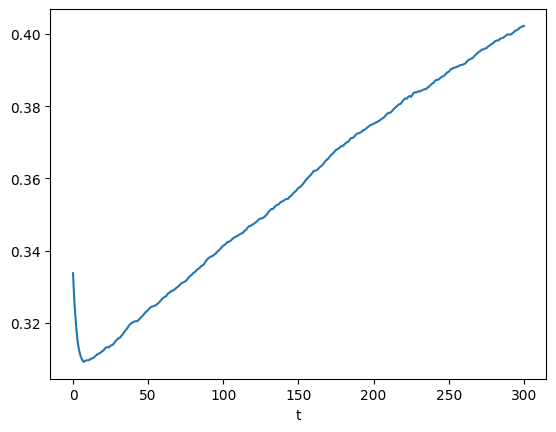

In [42]:
%matplotlib inline
data = results.variables.InnovationModel
ax = data["Gini Coefficient"].plot()
ax = data["fraction_adopte
# ax = data["remaining_resources"].plot()
# ax = data["total_money"].plot()
# data

In [43]:
json_string = data.to_json()
print(json_string)

{"fraction_adopted":{"0":0.0,"1":0.0,"2":0.0,"3":0.0,"4":0.0,"5":0.0,"6":0.0,"7":0.0,"8":0.0,"9":0.0,"10":0.0,"11":0.0,"12":0.0,"13":0.0,"14":0.0,"15":0.0,"16":0.0,"17":0.0,"18":0.0,"19":0.0,"20":0.0,"21":0.0,"22":0.0,"23":0.0,"24":0.0,"25":0.0,"26":0.0,"27":0.0,"28":0.0,"29":0.0,"30":0.0,"31":0.0,"32":0.0,"33":0.0,"34":0.0,"35":0.0,"36":0.0,"37":0.0,"38":0.0,"39":0.0,"40":0.0,"41":0.0,"42":0.0,"43":0.0,"44":0.0,"45":0.0,"46":0.0,"47":0.0,"48":0.0,"49":0.0,"50":0.0,"51":0.0,"52":0.0,"53":0.0,"54":0.0,"55":0.0,"56":0.0,"57":0.0,"58":0.0,"59":0.0,"60":0.0,"61":0.0,"62":0.0,"63":0.0,"64":0.0,"65":0.0,"66":0.0,"67":0.0,"68":0.0,"69":0.0,"70":0.0,"71":0.0,"72":0.0,"73":0.0,"74":0.0,"75":0.0,"76":0.0,"77":0.0,"78":0.0,"79":0.0,"80":0.0,"81":0.0,"82":0.0,"83":0.0,"84":0.0,"85":0.0,"86":0.0,"87":0.0,"88":0.0,"89":0.0,"90":0.0,"91":0.0,"92":0.0,"93":0.0,"94":0.0,"95":0.0,"96":0.0,"97":0.0,"98":0.0,"99":0.0,"100":0.0,"101":0.0,"102":0.0,"103":0.0,"104":0.0,"105":0.0,"106":0.0,"107":0.0,"108":0.0

In [60]:
plt.close()

### Interpretation

This shows that the fraction of total population adoption increased pretty dramatically and then plateaued at a fairly early epooch at around 89% adoption.

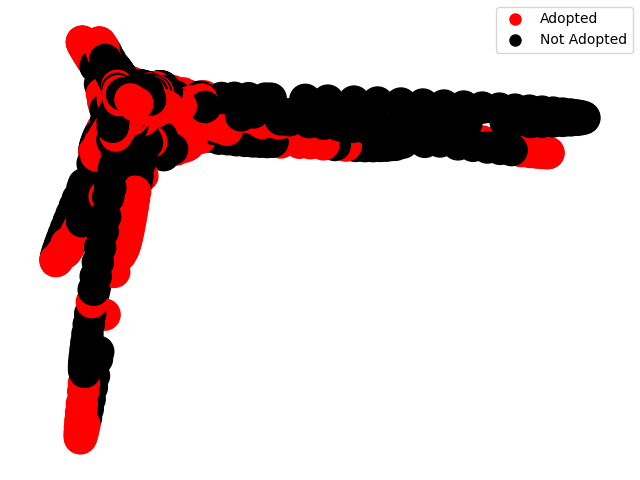

In [55]:
%matplotlib widget
# Enable interactive widgets for matplotlib (e.g., zooming and panning).

# Get the network and agent data from the model.
network = model.network  # Retrieve the network structure from the model.
adopted_states = [agent.adopted for agent in model.agents]  # Extract the adoption status (True/False) for all agents.

# Define node colors based on the adopted parameter.
# Nodes representing agents with 'adopted = True' will be red, otherwise black.
node_colors = ['red' if adopted else 'black' for adopted in adopted_states]

# Generate labels for nodes based on the agent's category index.
# Each node is labeled with its corresponding agent's category index as a string.
labels = [str(agent.category_idx) for agent in model.agents]
labels = {i: labels[i] for i in range(len(labels))}  # Map labels to node indices for visualization.

# Define the layout of the graph using the spring layout.
pos = nx.spring_layout(network.graph)  # Position nodes using a force-directed layout algorithm.
pos = nx.spectral_layout(network.graph)
# Draw the network graph using NetworkX's `draw` method.
nx.draw(
    network.graph,         # The graph to draw.
    pos,                   # Node positions.
    node_color=node_colors,  # Colors of the nodes based on adoption status.
    with_labels=False,     # Whether to show labels on the nodes (currently disabled).
    node_size=500          # Size of the nodes in the graph.
)

# Add a legend to explain node colors.
# The legend will have two entries: one for 'Adopted' (red) and one for 'Not Adopted' (black).
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='Adopted', markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Not Adopted', markerfacecolor='black', markersize=10)
])

# Add a title to the plot for better understanding.
plt.title("Agent Network with Node Colors Based on Adoption Status")

# Display the graph.
plt.show()
plt.close()  # Optionally close the plot if running in an interactive environment to avoid clutter.


This plot shows the network at the final state with the nodes that adopted the technology shown in red, and the nodes that did not shown in black. There are clear "islands of Ludites" that have not adopted the technology and wont because of thresholds needed for adoption.

## Playing around with networkx graphing

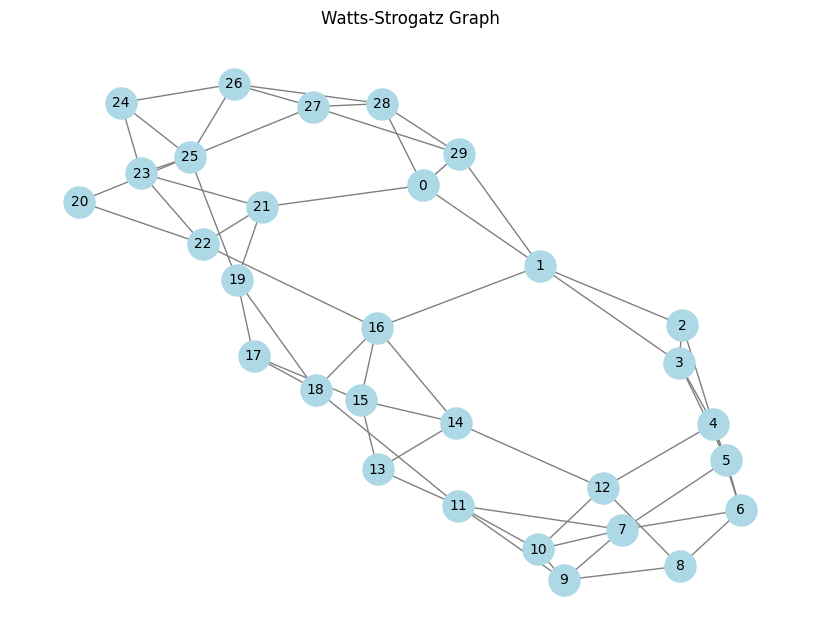

In [39]:
import networkx as nx
import matplotlib.pyplot as plt

# Parameters for the Watts-Strogatz graph
n = 30  # Number of nodes
k = 4   # Each node is connected to k nearest neighbors in ring topology
p = 0.1 # Probability of rewiring each edge

# Create a Watts-Strogatz small-world graph
G = nx.watts_strogatz_graph(n, k, p)

# Draw the graph
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)

# Show the plot
plt.title("Watts-Strogatz Graph")
plt.show()

In [6]:
parameters = {
    'population': [50, 100, 200],  # Test with different population sizes
    'categories': [
        ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard']
    ],  # Fixed categories
    'probabilities': [
        [0.05, 0.1, 0.35, 0.35, 0.15],  # Probabilities set 1
        [0.1, 0.2, 0.3, 0.3, 0.1],      # Probabilities set 2
    ],  # Vary probabilities to test adoption trends
    'thresholds': [
        [0.0, 0.1, 0.25, 0.5, 0.9],    # Thresholds set 1
        [0.0, 0.15, 0.3, 0.55, 0.8],   # Thresholds set 2
    ],  # Vary adoption thresholds
    'number_of_connections': [3, 4, 5],  # Test with different average connections
    'network_rewire_probability': [0.05, 0.1, 0.2],  # Explore varying rewiring probabilities
    'steps': [50, 100, 150],  # Simulate different durations
}

In [8]:
parameter_space = [
    {
        'population': 50,
        'categories': ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard'],
        'probabilities': [0.05, 0.1, 0.35, 0.35, 0.15],
        'thresholds': [0.0, 0.1, 0.25, 0.5, 0.9],
        'number_of_connections': 3,
        'network_rewire_probability': 0.05,
        'steps': 50
    },
    {
        'population': 50,
        'categories': ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard'],
        'probabilities': [0.05, 0.1, 0.35, 0.35, 0.15],
        'thresholds': [0.0, 0.1, 0.25, 0.5, 0.9],
        'number_of_connections': 3,
        'network_rewire_probability': 0.05,
        'steps': 100
    },
    {
        'population': 50,
        'categories': ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard'],
        'probabilities': [0.05, 0.1, 0.35, 0.35, 0.15],
        'thresholds': [0.0, 0.1, 0.25, 0.5, 0.9],
        'number_of_connections': 3,
        'network_rewire_probability': 0.05,
        'steps': 150
    },
    {
        'population': 50,
        'categories': ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard'],
        'probabilities': [0.05, 0.1, 0.35, 0.35, 0.15],
        'thresholds': [0.0, 0.1, 0.25, 0.5, 0.9],
        'number_of_connections': 3,
        'network_rewire_probability': 0.1,
        'steps': 50
    },
    {
        'population': 50,
        'categories': ['innovator', 'early_adopter', 'early_majority', 'late_majority', 'laggard'],
        'probabilities': [0.05, 0.1, 0.35, 0.35, 0.15],
        'thresholds': [0.0, 0.1, 0.25, 0.5, 0.9],
        'number_of_connections': 3,
        'network_rewire_probability': 0.1,
        'steps': 100
    },
    # More configurations...
]

In [ ]:
results_data = []

for parameters in parameter_space:
    model = InnovationModel(parameters)
    results = model.run()

    results_data.append(